# Example 3: Acceleration due to gravity

To illustrate how to use $\verb|emulator|$ and $\verb|calibrator|$ objects, we will give another example of a free-falling objects.

First, import the main libraries we use for this example:

In [1]:
import numpy as np
import sys
import os
from matplotlib import pyplot as plt
import scipy.stats as sps
current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
from base.emulation import emulator
from base.calibration import calibrator

## Data: Falling ball

The data include 63 field observations at 21 heights, with three replicates at each height. Let's read the real data first, and then visualize:

In [2]:
# Read the data
ball = np.loadtxt('ball.csv', delimiter=',')
m = len(ball)
#height
xrep = np.reshape(ball[:, 0], (m, 1))
x = xrep[0:21]
#time
y = np.reshape(ball[:, 1], ((m, 1)))

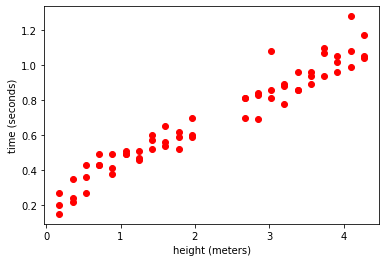

In [3]:
# Observe the data
plt.scatter(xrep, y, color = 'red')
plt.xlabel("height (meters)")
plt.ylabel("time (seconds)")
plt.show()

## Computer model experiments

The time $t$ to drop the ball at a distance $h$ is $t = \sqrt{2h/g}$ for gravity $g$. Here, the gravity $g$ is our calibration parameter $\theta$ bacause we don't know the actual value of $g$ for the location the ball is dropped. We consider the computer implementation $f(x, \theta)$ of the mathematical model that maps $(h, g)$ to $(x, \theta)$ in $[0, 1]$ to compute $t$. 

In [4]:
# Computer implementation of the mathematical model
def timedrop(x, theta, hr, gr):
    # Assume x and theta are within (0, 1)
    min_g = min(gr)
    range_g = max(gr) - min(gr)
    min_h = min(hr)
    range_h = max(hr) - min_h
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        g = range_g*theta[k] + min_g
        h = range_h*x + min_h
        f[k, :] = np.sqrt(2*h/g).reshape(x.shape[0])
    return f.T

We run the `timedrop()` function at 21 different unique locations such that $\mathbf{x}$ is $m \times p$ input matrix with $m = 21$ and $p = 1$.

## Prior specification

For this example, we define a uniform prior for $g$ such that $g$ ~ $U(6, 15)$. We perform computer model simulations at $n = 100$ random settings of the calibration parameter $g$, and obtain $m \times n$ model output matrix $\mathbf{f}$.

In [5]:
# Define prior
class prior_balldrop:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        if theta.ndim > 1.5:
            return np.squeeze(sps.uniform.logpdf(theta[:, 0], 0, 1))
        else:
            return np.squeeze(sps.uniform.logpdf(theta, 0, 1))

    def rnd(n):
        return np.vstack((sps.uniform.rvs(0, 1, size=n)))

In [6]:
# Draw 100 random parameters from uniform prior
n = 100
theta = prior_balldrop.rnd(n)
theta_range = np.array([6, 15])

# Standardize 
x_range = np.array([min(x), max(x)])
x_std = (x - min(x))/(max(x) - min(x))
xrep_std = (xrep - min(xrep))/(max(xrep) - min(xrep))

# Obtain computer model output
f = timedrop(x_std, theta, x_range, theta_range)

print(np.shape(theta))
print(np.shape(x_std))
print(np.shape(f))

(100, 1)
(21, 1)
(21, 100)


## Model emulation

Let's build an emulator for computer model runs:

In [7]:
emulator_1 = emulator(x = x_std, theta = theta, f = f, method = 'PCGPwM')

0


In [8]:
emulator_2 = emulator(x = x_std, theta = theta, f = f, method = 'PCGP_ozge', args = {'is_pca': True})

Function supplementtheta not found in module!
no of pcs: 2


### Comparison of emulation methodologies

One way to test the accuracy of the emulators is to create a hold-out simulation run, and compare the predicted values from the emulator and simulated values. To do this, let's first generate random draws of parameters, and evaluate the computer model at those values.

In [9]:
#Generate random reasonable theta values
n_test = 1000
theta_test = prior_balldrop.rnd(n_test)
print(np.shape(theta_test))

# Obtain computer model output
f_test = timedrop(x_std, theta_test, x_range, theta_range)
print(np.shape(f_test))

#Predict
p_1 = emulator_1.predict(x_std, theta_test)
p_1_mean = p_1.mean()
p_2 = emulator_2.predict(x_std, theta_test)
p_2_mean = p_2.mean()

print('SSE = ', np.sum((p_1_mean - f_test)**2))
print('SSE = ', np.sum((p_2_mean - f_test)**2))

print('Rsq = ', 1 - np.sum(np.square(p_1_mean - f_test))/np.sum(np.square(f_test.T - np.mean(f_test, axis = 1))))
print('Rsq = ', 1 - np.sum(np.square(p_2_mean - f_test))/np.sum(np.square(f_test.T - np.mean(f_test, axis = 1))))

(1000, 1)
(21, 1000)
SSE =  1.6788571887684963e-06
SSE =  0.00036397740243351433
Rsq =  0.9999999899376304
Rsq =  0.9999978184712871


## Model calibration

In [10]:
def plot_pred(x_std, xrep, y, cal, theta_range):
    
    fig, axs = plt.subplots(1, 4, figsize=(14, 3))

    cal_theta = cal.theta.rnd(1000) 
    cal_theta = cal_theta*(theta_range[1] - theta_range[0]) + theta_range[0]  
    axs[0].plot(cal_theta)
    axs[1].boxplot(cal_theta)
    axs[2].hist(cal_theta)
    
    post = cal.predict(x_std)
    rndm_m = post.rnd(s = 1000)
    upper = np.percentile(rndm_m, 97.5, axis = 0)
    lower = np.percentile(rndm_m, 2.5, axis = 0)
    median = np.percentile(rndm_m, 50, axis = 0)

    axs[3].plot(xrep[0:21].reshape(21), median, color = 'black')
    axs[3].fill_between(xrep[0:21].reshape(21), lower, upper, color = 'grey')
    axs[3].plot(xrep, y, 'ro', markersize = 5, color='red')
    
    plt.show()

n_acc rate= 0.278


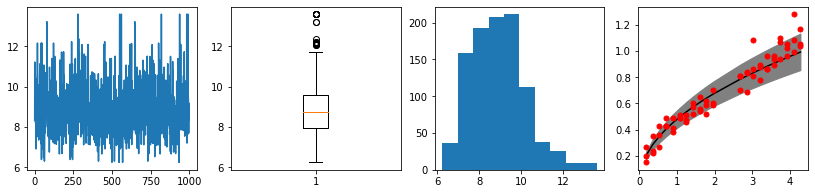

In [11]:
obsvar = np.maximum(0.2*y, 0.1)

# Fit a calibrator with emulator 1 via via method = 'MLcal' and 'sampler' = 'mh' 
cal_1 = calibrator(emu = emulator_1, y = y, x = xrep_std, thetaprior = prior_balldrop, 
                   method = 'MLcal', yvar = obsvar, 
                   args = {'theta0': np.array([0.4]), 
                           'numsamp' : 1000, 
                           'stepType' : 'normal', 
                           'stepParam' : [0.6]})

plot_pred(x_std, xrep, y, cal_1, theta_range)

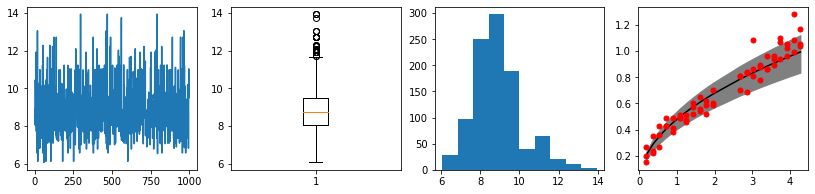

In [12]:
# Fit a calibrator via method = 'MLcal' and 'sampler' : 'plumlee'
cal_2 = calibrator(emu = emulator_1, y = y, x = xrep_std, thetaprior = prior_balldrop, 
                   method = 'MLcal', yvar = obsvar, 
                   args = {'sampler' : 'plumlee'})

plot_pred(x_std, xrep, y, cal_2, theta_range)

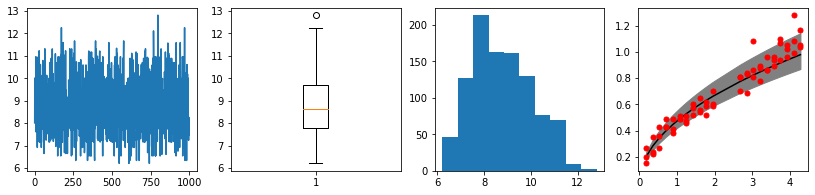

In [13]:
# Fit a calibrator via method = 'directbayes' and 'sampler' : 'plumlee'
cal_3 = calibrator(emu = emulator_1, y = y, x = xrep_std, thetaprior = prior_balldrop, 
                   method = 'directbayes', yvar = obsvar)

plot_pred(x_std, xrep, y, cal_3, theta_range)